# Sommaire

* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) Préparation des données](#ii)
* [III) Modèle initial](#iii)
* [IV) ARI](#iv)
* [V) Evolution de la distribution des features](#v)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>
Dans ce notebook, nous allons simuler l'évolution de la stabilité du clustering dans l'optique de faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente.

# I) Importation des données <a class="anchor" id="i"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
data_gb = pd.read_pickle('data_gb.pkl')
data_gb

,customer_unique_id,nb_commandes,panier_moyen,review_score_moyen,jours_depuis_derniere_cmd,date_derniere_cmd
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,5.0,113,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,4.0,116,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,86.22,3.0,539,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,4.0,323,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,5.0,290,2017-11-14 19:45:42
...,...,...,...,...,...,...
95059,fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,5.0,449,2017-06-08 21:00:36
95060,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,4.0,264,2017-12-10 20:07:56
95061,ffff371b4d645b6ecea244b27531430a,1,112.46,5.0,570,2017-02-07 15:49:16
95062,ffff5962728ec6157033ef9805bacc48,1,133.69,5.0,121,2018-05-02 15:17:41


# II) Préparation des données <a class="anchor" id="ii"></a>
Le jeu de données allant de 01-2017 à 08-2018, je décide de partir d'une période de base qui contient les dernières commandes passées la première année. Ensuite, pour mesurer la stabilité dans le temps, nous injecterons progressivement les dernières commandes passées entre 01-2018 et 08-2018 en recalculant à chaque fois l'indice de Rand ajusté par rapport aux données de la période de base.

In [3]:
#On créé notre baseline
baseline = data_gb[data_gb['date_derniere_cmd'].dt.year == 2017].copy().reset_index(drop=True)

#On se sépare de customer_unique_id
baseline = baseline.iloc[:, 1:]
baseline

,nb_commandes,panier_moyen,review_score_moyen,jours_depuis_derniere_cmd,date_derniere_cmd
0,1,86.22,3.0,539,2017-03-10 21:05:03
1,1,43.62,4.0,323,2017-10-12 20:29:41
2,1,196.89,5.0,290,2017-11-14 19:45:42
3,1,150.12,4.0,545,2017-03-04 23:32:12
4,1,29.00,3.0,409,2017-07-18 09:23:10
...,...,...,...,...,...
42674,1,167.32,5.0,247,2017-12-27 22:36:41
42675,1,2067.42,5.0,449,2017-06-08 21:00:36
42676,1,84.58,4.0,264,2017-12-10 20:07:56
42677,1,112.46,5.0,570,2017-02-07 15:49:16


In [4]:
#Même chose pour les périodes
periodes = data_gb[data_gb['date_derniere_cmd'].dt.year == 2018].copy().reset_index(drop=True)
periodes = periodes.iloc[:, 1:]
periodes

,nb_commandes,panier_moyen,review_score_moyen,jours_depuis_derniere_cmd,date_derniere_cmd
0,1,141.90,5.0,113,2018-05-10 10:56:27
1,1,27.19,4.0,116,2018-05-07 11:11:27
2,1,166.98,4.0,148,2018-04-05 19:33:16
3,1,35.38,4.0,133,2018-04-20 12:57:23
4,1,419.18,1.0,184,2018-02-28 11:15:41
...,...,...,...,...,...
52380,1,82.51,5.0,42,2018-07-20 13:47:30
52381,1,2844.96,5.0,60,2018-07-02 16:39:59
52382,1,63.42,4.0,16,2018-08-15 10:26:57
52383,1,710.70,1.0,142,2018-04-11 00:34:32


In [5]:
#J'ignore encore si je souhaite actualiser par mois ou par semaine alors je créé 2 nouvelles colonnes
periodes['mois'] = periodes['date_derniere_cmd'].dt.strftime("Mois %m")
periodes['semaines'] = periodes['date_derniere_cmd'].dt.strftime("Semaine %U")
periodes

,nb_commandes,panier_moyen,review_score_moyen,jours_depuis_derniere_cmd,date_derniere_cmd,mois,semaines
0,1,141.90,5.0,113,2018-05-10 10:56:27,Mois 05,Semaine 18
1,1,27.19,4.0,116,2018-05-07 11:11:27,Mois 05,Semaine 18
2,1,166.98,4.0,148,2018-04-05 19:33:16,Mois 04,Semaine 13
3,1,35.38,4.0,133,2018-04-20 12:57:23,Mois 04,Semaine 15
4,1,419.18,1.0,184,2018-02-28 11:15:41,Mois 02,Semaine 08
...,...,...,...,...,...,...,...
52380,1,82.51,5.0,42,2018-07-20 13:47:30,Mois 07,Semaine 28
52381,1,2844.96,5.0,60,2018-07-02 16:39:59,Mois 07,Semaine 26
52382,1,63.42,4.0,16,2018-08-15 10:26:57,Mois 08,Semaine 32
52383,1,710.70,1.0,142,2018-04-11 00:34:32,Mois 04,Semaine 14


In [6]:
#Petite vérification (la dernière semaine est mal renseignée, sinon rien à signaler)
periodes['semaines'].value_counts()

semaines
Semaine 31    2037
Semaine 18    1947
Semaine 30    1936
Semaine 32    1842
Semaine 19    1838
Semaine 08    1802
Semaine 02    1705
Semaine 11    1691
Semaine 01    1688
Semaine 17    1677
Semaine 16    1657
Semaine 15    1648
Semaine 29    1636
Semaine 07    1626
Semaine 09    1597
Semaine 13    1570
Semaine 28    1569
Semaine 03    1560
Semaine 10    1548
Semaine 05    1544
Semaine 23    1536
Semaine 06    1531
Semaine 04    1490
Semaine 14    1458
Semaine 25    1411
Semaine 22    1407
Semaine 12    1404
Semaine 24    1385
Semaine 26    1214
Semaine 33    1195
Semaine 00    1131
Semaine 20     991
Semaine 21     972
Semaine 27     940
Semaine 34     202
Name: count, dtype: int64

# III) Modèle initial <a class="anchor" id="iii"></a>

In [7]:
#On commence par centrer et réduire la baseline
scaler_initial = StandardScaler()
baseline_scaled = scaler_initial.fit_transform(baseline.iloc[:, :4])
baseline_scaled[:5]

array([[-0.16172662, -0.31307365, -0.80880694,  1.6567479 ],
       [-0.16172662, -0.5014947 , -0.06053144, -0.60016147],
       [-0.16172662,  0.17642303,  0.68774407, -0.94496707],
       [-0.16172662, -0.03044206, -0.06053144,  1.71943983],
       [-0.16172662, -0.5661594 , -0.80880694,  0.29842282]])

In [8]:
#On applique le kmeans avec les mêmes paramètres qu'on a retenu dans le dernier notebook et on enregistre les clusters
kmeans_initial = KMeans(n_clusters=5, n_init=20)
kmeans_initial.fit(baseline_scaled)
baseline_clusters = kmeans_initial.labels_
ari_initial = adjusted_rand_score(baseline_clusters, baseline_clusters)

# IV) ARI <a class="anchor" id="iv"></a>

In [9]:
#On s'attaque enfin à l'ARI, on commence par une liste pour stocker les scores
ari_scores = [ari_initial]

#Liste des mois uniques
mois_uniques = periodes['mois'].sort_values().unique()

#Copie de la baseline pour ajouter les mois progressivement
baseline_ext = baseline.copy()

#Puis on itère sur chaque mois dans periodes
for mois in mois_uniques:
    #Sélection des données pour le mois actuel
    periode_data = periodes[periodes['mois'] == mois]

    #Concaténation avec la baseline pour former le nouveau jeu de données
    combined_data = pd.concat([baseline_ext, periode_data], axis=0).reset_index(drop=True)

    #Entraînement d'un nouveau kmeans sur les données combinées, puis on récupère les clusters
    combined_scaled = scaler_initial.transform(combined_data.iloc[:, :4])
    kmeans_periode = KMeans(n_clusters=5, n_init=20, random_state=42)
    kmeans_periode.fit(combined_scaled)
    combined_data['clusters_periode'] = kmeans_periode.labels_

    #On isole les clusters des clients initiaux, calculés avec les données de la période en cours
    periode_clusters = combined_data[combined_data['date_derniere_cmd'].dt.year == 2017]['clusters_periode']

    #Calcul de l'ARI pour les clusters de références et les nouveaux clusters
    ari_score = adjusted_rand_score(periode_clusters, baseline_clusters)

    #On stocke l'ARI dans la liste
    ari_scores.append(ari_score)

    #Ajout de la mois à baseline_ext pour la prochaine itération
    baseline_ext = pd.concat([baseline_ext, periode_data], axis=0).reset_index(drop=True)

#Les résultats
print("Evolution de l'ARI par mois :")
print()
print(f"Baseline : {ari_initial}")
for i, ari in enumerate(ari_scores[1:]):
    print(f"{i+1} mois : {ari}")

Evolution de l'ARI par mois :

Baseline : 1.0
1 mois : 0.8063144937152961
2 mois : 0.6883845127753258
3 mois : 0.5349261598555703
4 mois : 0.4315980226231254
5 mois : 0.35450323327786887
6 mois : 0.28970491372735174
7 mois : 0.237961659484894
8 mois : 0.20645452857911004


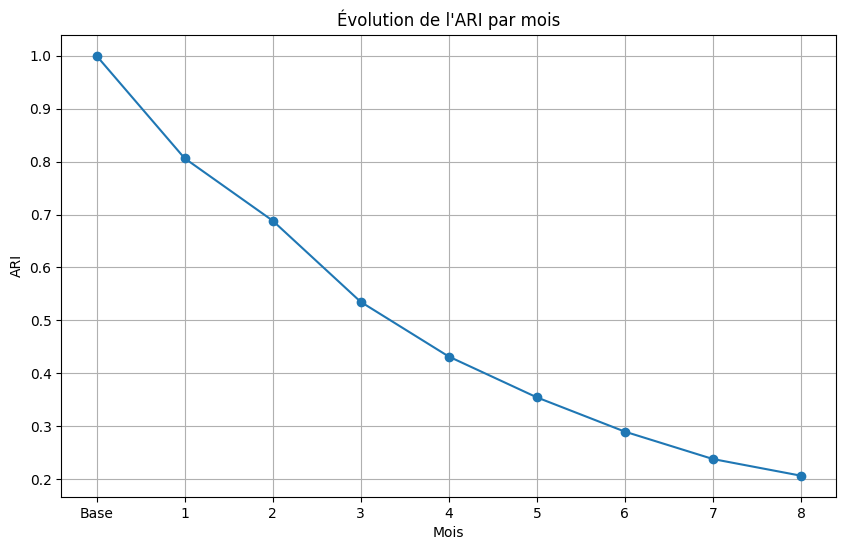

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(ari_scores)), ari_scores, marker='o', linestyle='-')
plt.xlabel("Mois")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI par mois")
plt.xticks(ticks=range(len(ari_scores)), labels=["Base"] + [f"{i+1}" for i in range(len(ari_scores)-1)])
plt.grid(True)
plt.show()

In [11]:
#Par curiosité on regarde par semaine aussi
#On réinitialiste la liste
ari_scores = [ari_initial]

#Liste des semaines uniques
semaines_uniques = periodes['semaines'].sort_values().unique()

#Copie de la baseline pour ajouter les semaines progressivement
baseline_ext = baseline.copy()

#Puis on itère sur chaque semaine dans periodes
for semaine in semaines_uniques:
    #Sélection des données pour la semaine actuelle
    periode_data = periodes[periodes['semaines'] == semaine]

    #Concaténation avec la baseline pour former le nouveau jeu de données
    combined_data = pd.concat([baseline_ext, periode_data], axis=0).reset_index(drop=True)

    #Entraînement d'un nouveau kmeans sur les données combinées, puis on récupère les clusters
    combined_scaled = scaler_initial.transform(combined_data.iloc[:, :4])
    kmeans_periode = KMeans(n_clusters=5, n_init=20, random_state=42)
    kmeans_periode.fit(combined_scaled)
    combined_data['clusters_periode'] = kmeans_periode.labels_

    #On isole les clusters des clients initiaux, calculés avec les données de la période en cours
    periode_clusters = combined_data[combined_data['date_derniere_cmd'].dt.year == 2017]['clusters_periode']

    #Calcul de l'ARI pour les clusters de références et les nouveaux clusters
    ari_score = adjusted_rand_score(periode_clusters, baseline_clusters)

    #On stocke l'ARI dans la liste
    ari_scores.append(ari_score)

    #Ajout de la semaine à baseline_ext pour la prochaine itération
    baseline_ext = pd.concat([baseline_ext, periode_data], axis=0).reset_index(drop=True)

#Les résultats
print("Evolution de l'ARI par semaine :")
print()
print(f"Baseline : {ari_initial}")
for i, ari in enumerate(ari_scores[1:]):
    print(f"{i+1} semaines : {ari}")

Evolution de l'ARI par semaine :

Baseline : 1.0
1 semaines : 0.9592790136040628
2 semaines : 0.9130418626806842
3 semaines : 0.8751606504732075
4 semaines : 0.825568935152601
5 semaines : 0.7977065066259946
6 semaines : 0.7638451885697798
7 semaines : 0.7427562472026179
8 semaines : 0.7036321653591282
9 semaines : 0.6777575923494437
10 semaines : 0.6495283671844739
11 semaines : 0.6301558207200196
12 semaines : 0.5643490201821546
13 semaines : 0.5348762115140527
14 semaines : 0.5052702327123575
15 semaines : 0.4856026540969961
16 semaines : 0.46030526091857343
17 semaines : 0.43865595254260675
18 semaines : 0.4177434635050935
19 semaines : 0.39072282399396474
20 semaines : 0.3703000811337109
21 semaines : 0.35967172909311584
22 semaines : 0.3497228207898318
23 semaines : 0.3325757211165581
24 semaines : 0.3162148521033671
25 semaines : 0.3013384792558262
26 semaines : 0.2894576003404256
27 semaines : 0.2820241378677885
28 semaines : 0.2709185916417454
29 semaines : 0.2595067373504124


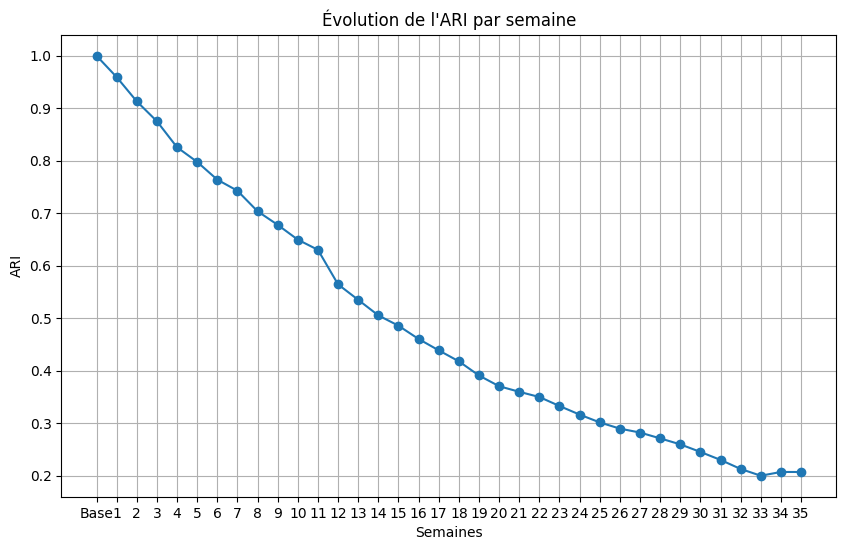

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(ari_scores)), ari_scores, marker='o', linestyle='-')
plt.xlabel("Semaines")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI par semaine")
plt.xticks(ticks=range(len(ari_scores)), labels=["Base"] + [f"{i+1}" for i in range(len(ari_scores)-1)])
plt.grid(True)
plt.show()

Les découpages par mois et par semaine présentent des résultats similaires. Il semblerait qu'une mise à jour du modèle une fois toutes les 4 à 5 semaines soit idéale afin que celui-ci reste pertinent.
# V) Evolution de la distribution des features <a class="anchor" id="v"></a>

In [13]:
from scipy.stats import ks_2samp

#Comparaison de la distribution de chaque feature entre la baseline et chaque mois
ks_results = {}
for feature in baseline.columns[:4]:
    ks_results[feature] = []
    for mois in mois_uniques:
        periode_data = periodes[periodes['mois'] == mois][feature]
        ks_stat, p_value = ks_2samp(baseline[feature], periode_data)
        ks_results[feature].append((ks_stat, p_value))

#Résultats
for feature, results in ks_results.items():
    print()
    print(f"{feature}:")
    print()
    for i, (ks_stat, p_value) in enumerate(results):
        print(f"  {i+1} mois : KS={ks_stat}, p-value={p_value}")


nb_commandes:

  1 mois : KS=0.0031368971224623454, p-value=0.9999999882482778
  2 mois : KS=0.009441429411755964, p-value=0.7004277773135652
  3 mois : KS=0.003877689341517887, p-value=0.999988892354493
  4 mois : KS=0.0021118705023712714, p-value=1.0
  5 mois : KS=0.00712807140763605, p-value=0.9278149816132424
  6 mois : KS=0.007399429019834702, p-value=0.931420412538079
  7 mois : KS=0.005797104669104103, p-value=0.9932575640105709
  8 mois : KS=0.008307199828993861, p-value=0.8319970866037028

panier_moyen:

  1 mois : KS=0.012865599525499843, p-value=0.2726320156198827
  2 mois : KS=0.02300271893848249, p-value=0.0054575712772611485
  3 mois : KS=0.03080421890364049, p-value=2.2954274311526216e-05
  4 mois : KS=0.035060917053315155, p-value=1.2068182129772872e-06
  5 mois : KS=0.044214927471387555, p-value=2.7478001126965575e-10
  6 mois : KS=0.04330890406350513, p-value=4.406332987828248e-09
  7 mois : KS=0.036222865715953234, p-value=1.4911686370451639e-06
  8 mois : KS=0.0154

Les p-values sont toutes proches de 1 pour nb_commandes, sans surprise puisque 97% des clients n'ont commandé qu'une fois. Les distributions sont similaires.

En revanche, à quelques exceptions près, les p-values pour panier_moyen ainsi que review_score_moyen sont inférieures à 0.05, ce qui suggère des distributions diffèrentes.

Les p-values sont toutes nulles pour jours_depuis_derniere_cmd, sans surprise car la baseline va de ~250 à 600 jours alors que les mois ne couvrent qu'environ 30 jours.

In [14]:
#On ajoute une colonne mois dans la baseline
baseline['mois'] = 'Base'

#On concatène avec les périodes
data_final = pd.concat([baseline, periodes], axis=0).reset_index(drop=True)
data_final

,nb_commandes,panier_moyen,review_score_moyen,jours_depuis_derniere_cmd,date_derniere_cmd,mois,semaines
0,1,86.22,3.0,539,2017-03-10 21:05:03,Base,NaN
1,1,43.62,4.0,323,2017-10-12 20:29:41,Base,NaN
2,1,196.89,5.0,290,2017-11-14 19:45:42,Base,NaN
3,1,150.12,4.0,545,2017-03-04 23:32:12,Base,NaN
4,1,29.00,3.0,409,2017-07-18 09:23:10,Base,NaN
...,...,...,...,...,...,...,...
95059,1,82.51,5.0,42,2018-07-20 13:47:30,Mois 07,Semaine 28
95060,1,2844.96,5.0,60,2018-07-02 16:39:59,Mois 07,Semaine 26
95061,1,63.42,4.0,16,2018-08-15 10:26:57,Mois 08,Semaine 32
95062,1,710.70,1.0,142,2018-04-11 00:34:32,Mois 04,Semaine 14


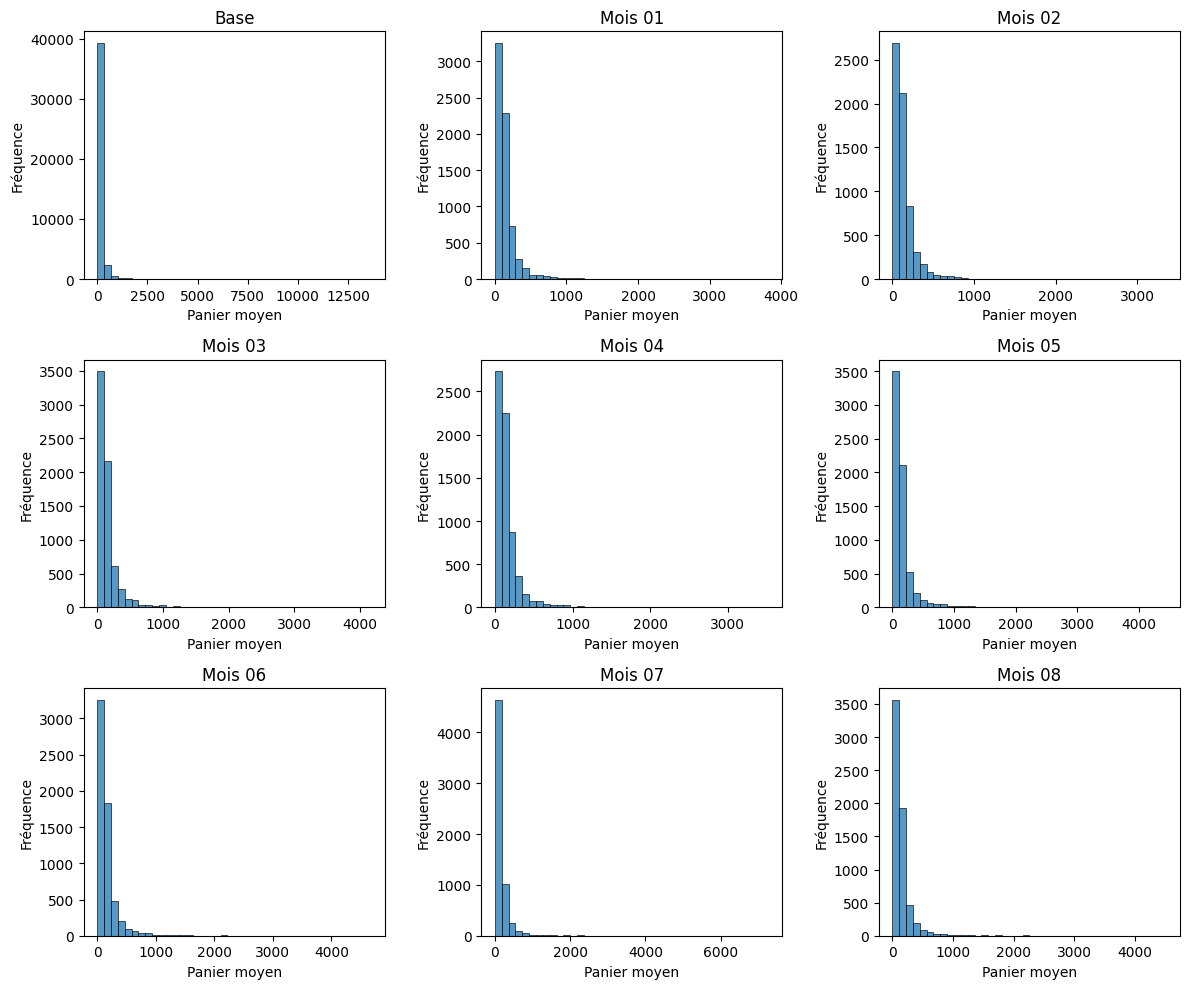

In [15]:
#On actualise notre liste de mois uniques
mois_uniques = np.insert(mois_uniques, 0, 'Base')

#On viusalise la distribution des paniers moyens
plt.figure(figsize=(12, 10))
for i, mois in enumerate(mois_uniques):
    mois_data = data_final[data_final['mois'] == mois]
    plt.subplot(3, 3, i+1)
    sns.histplot(x='panier_moyen', data=mois_data, bins=40)
    plt.title(mois)
    plt.xlabel('Panier moyen')
    plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

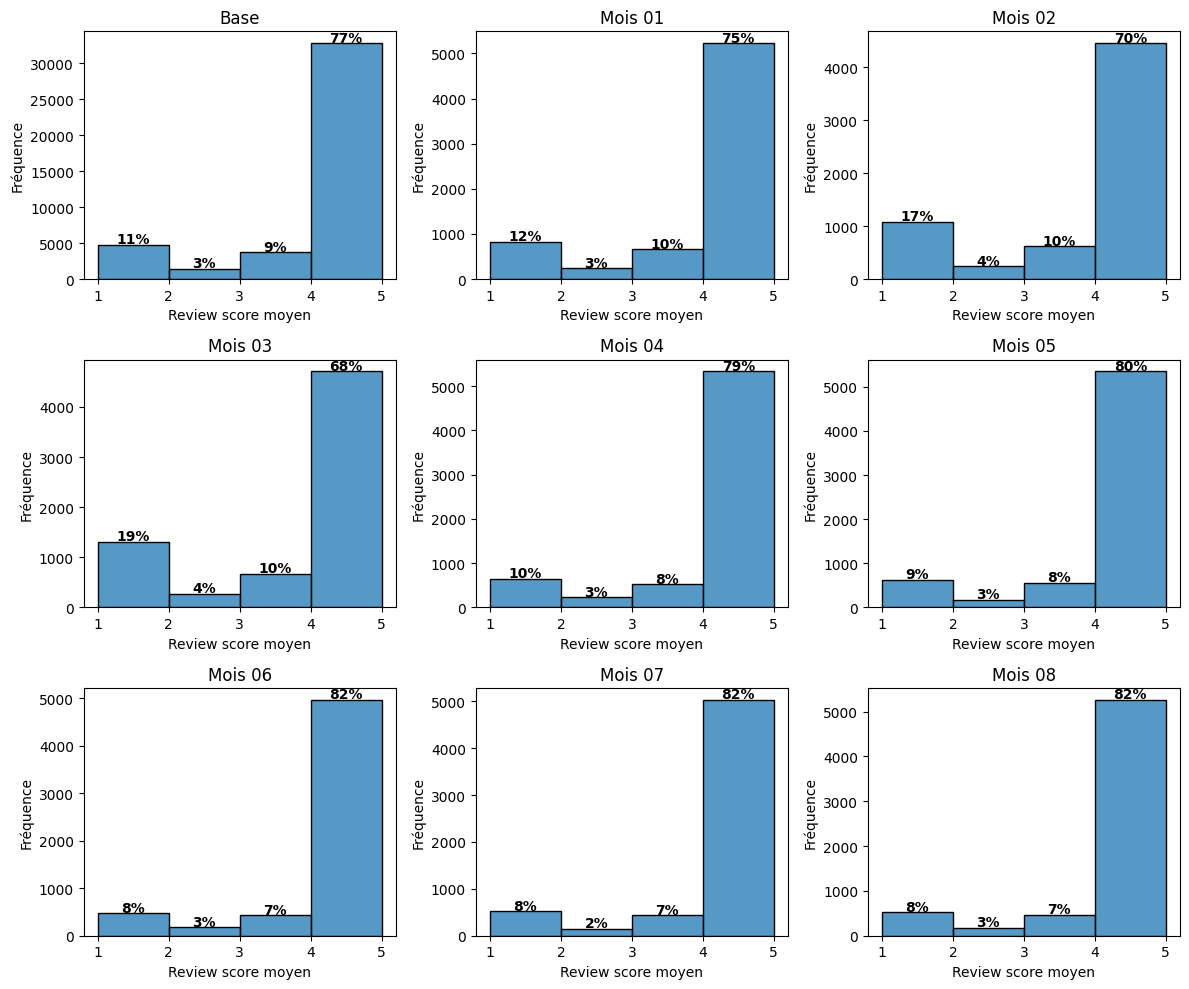

In [16]:
#Même chose avec le review score moyen
plt.figure(figsize=(12, 10))
for i, mois in enumerate(mois_uniques):
    mois_data = data_final[data_final['mois'] == mois]
    plt.subplot(3, 3, i+1)
    sns.histplot(x='review_score_moyen', data=mois_data, bins=4)
    plt.title(mois)
    plt.xlabel('Review score moyen')
    plt.ylabel('Fréquence')
    
    #Annotations
    for p in plt.gca().patches:
        percentage = round((p.get_height() / len(mois_data)) * 100)
        plt.gca().annotate(f'{percentage}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 4), textcoords='offset points', 
                           weight='bold', size=10)
        
plt.tight_layout()
plt.show()

Malgré certains résultats du test de Kolmogorov-Smirnov, rien de choquant en ce qui concerne la distribution des variables dans le temps.
# Conclusion <a class="anchor" id="conclusion"></a>
Comme mentionné plus haut, je suggère une mise à jour du modèle toutes les 4 à 5 semaines afin qu'il reste pertinent.